In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [21]:
METRICS = ["Cramer-von Mises Distance", "Frechet Distance", "Hausdorff Distance", "Wasserstein Distance"]
MODELS = ["no_noise", "linear_noise", "0.025_noise", "0.05_noise", "0.075_noise"]
Nx, Ny= 50, 50  # Grid points
Lx, Ly = 1.0, 1.0  # Domain size in meters
x, y = np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)  # Centered at (0,0)
cx, cy = 1, 1
s = 5e-5
TEND = 0.1
DT = 0.001

In [12]:
'''
Aim: To use the average median of the 0.1% quantile for cx, cy, s to generate solutions 
'''

def generate_solution(nx, ny, Lx, Ly, cx, cy, s):
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    dt = DT
    tend = TEND
    t = 0

    cfl_x, cfl_y = cx * dt/dx, cy * dt/dy
    diff_x, diff_y = s * dt/dx**2, s * dt/dy**2

    u = np.zeros((nx+2, ny+2))
    sol = []
    source_x, source_y = nx // 2, ny // 2
    u[source_x, source_y] = 1.0 # Cocentration starts from the central peak
    
    while t < tend:
        unew = u.copy()
        sol.append(u[1:-1, 1:-1])

         # Advection (Upwind Scheme)
        unew[1:-1, 1:-1] -= cfl_x * (u[1:-1, 1:-1] - u[1:-1, :-2])
        unew[1:-1, 1:-1] -= cfl_y * (u[1:-1, 1:-1] - u[:-2, 1:-1])
    
        # Diffusion (Central Differencing)
        unew[1:-1, 1:-1] += diff_x * (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2])
        unew[1:-1, 1:-1] += diff_y * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1])

        u = unew
        t += dt

    '''
    We transpose the axis the solution. Such that:
    - Axis 0: x
    - Axis 1: y
    - Axis 2: time
    Interpretation: For each x-grid, we have the concentration of each y-grid over time.
    Essentially, the (ny, 1200) array represents the concentration at each y over the time.
    So we have an array of size 1200 for each y. (A curve)
    '''
    sol = np.transpose(sol, (1, 2, 0))
    return np.array(sol)

In [26]:
df = pd.read_csv("dataframe/all_summary_statistics.csv")
df_01 = df[df["quantile"] == "0.1%"]
cx = df_01[(df_01["param"] == "cx") & (df_01["summary_statistic"] == "Median")].reset_index(drop=True)
cy = df_01[(df_01["param"] == "cy") & (df_01["summary_statistic"] == "Median")].reset_index(drop=True)
s = df_01[(df_01["param"] == "s") & (df_01["summary_statistic"] == "Median")].reset_index(drop=True)

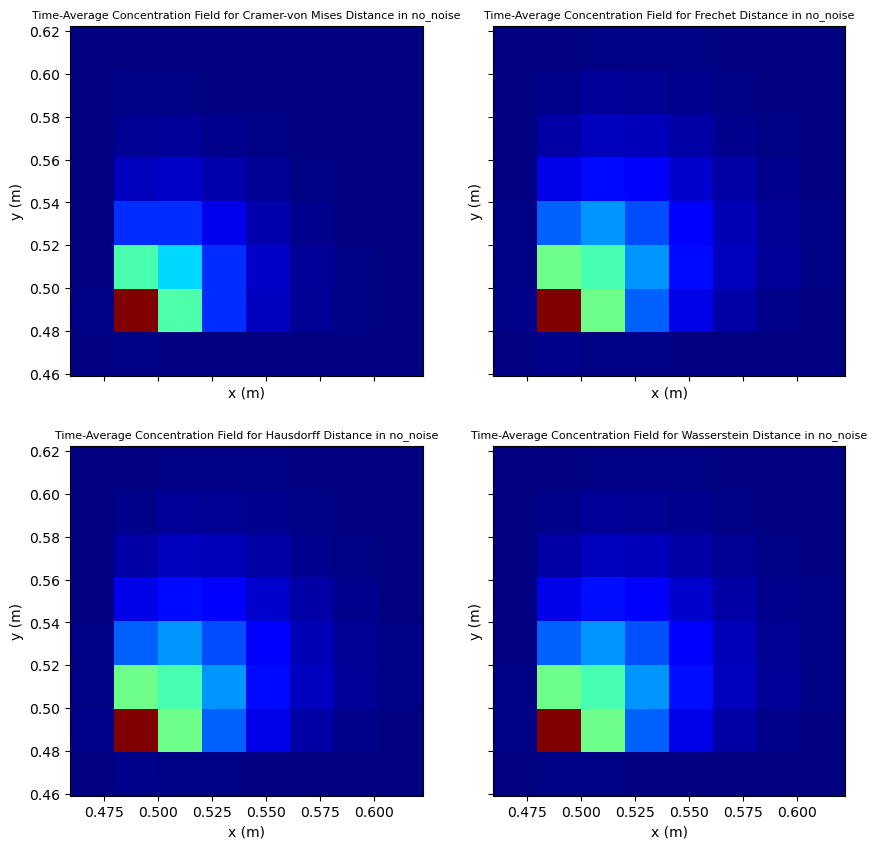

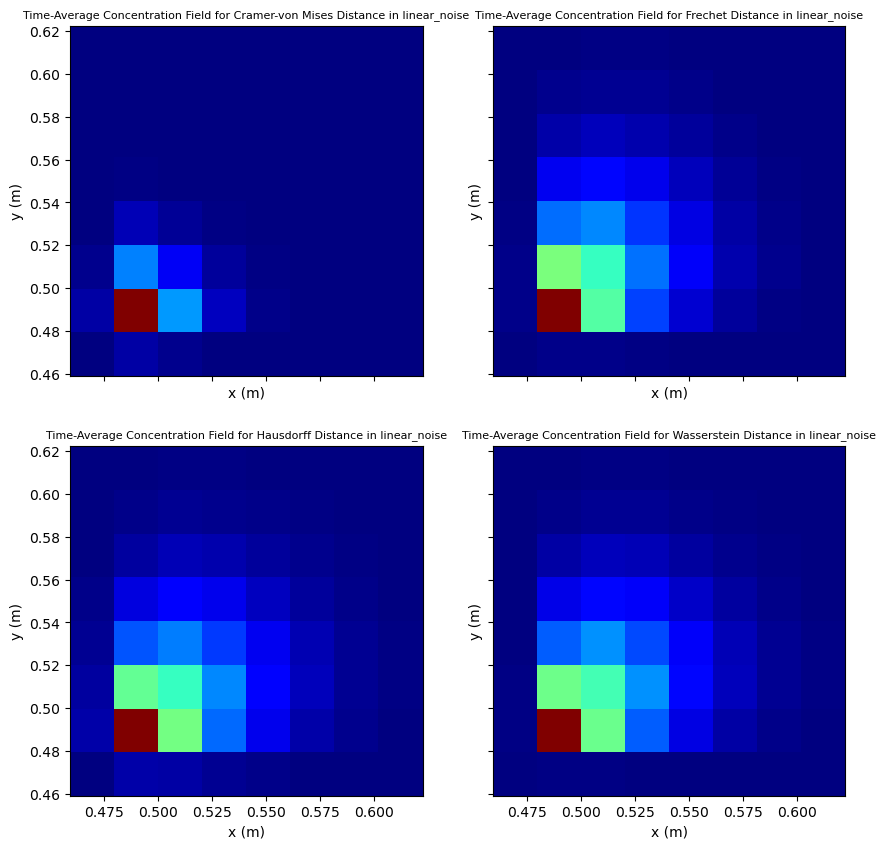

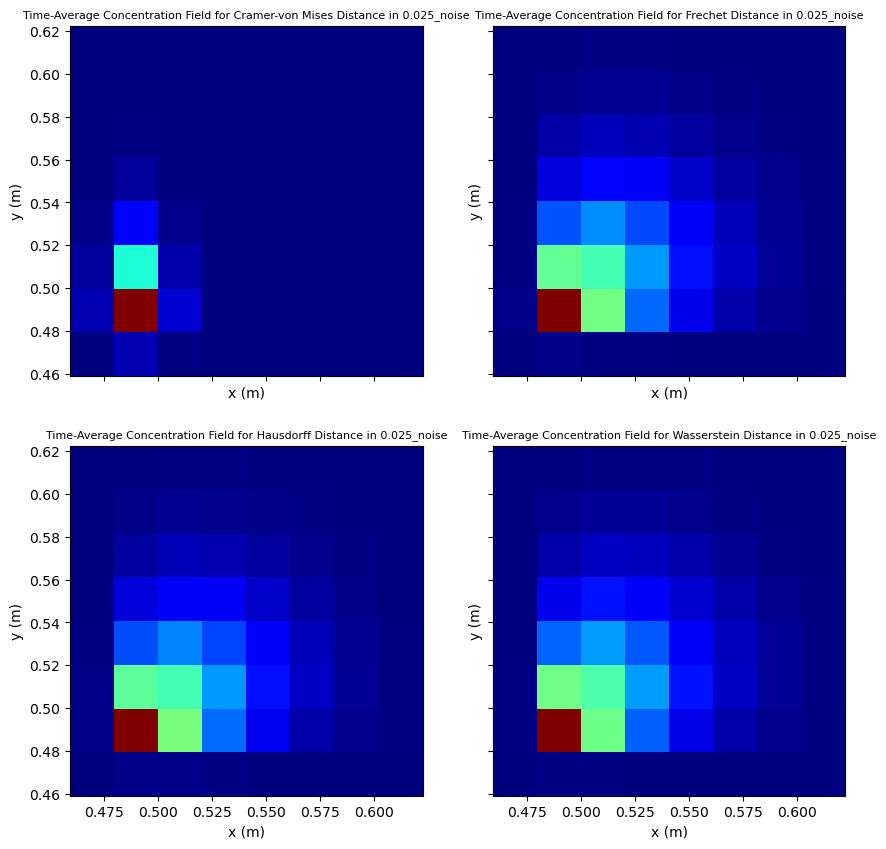

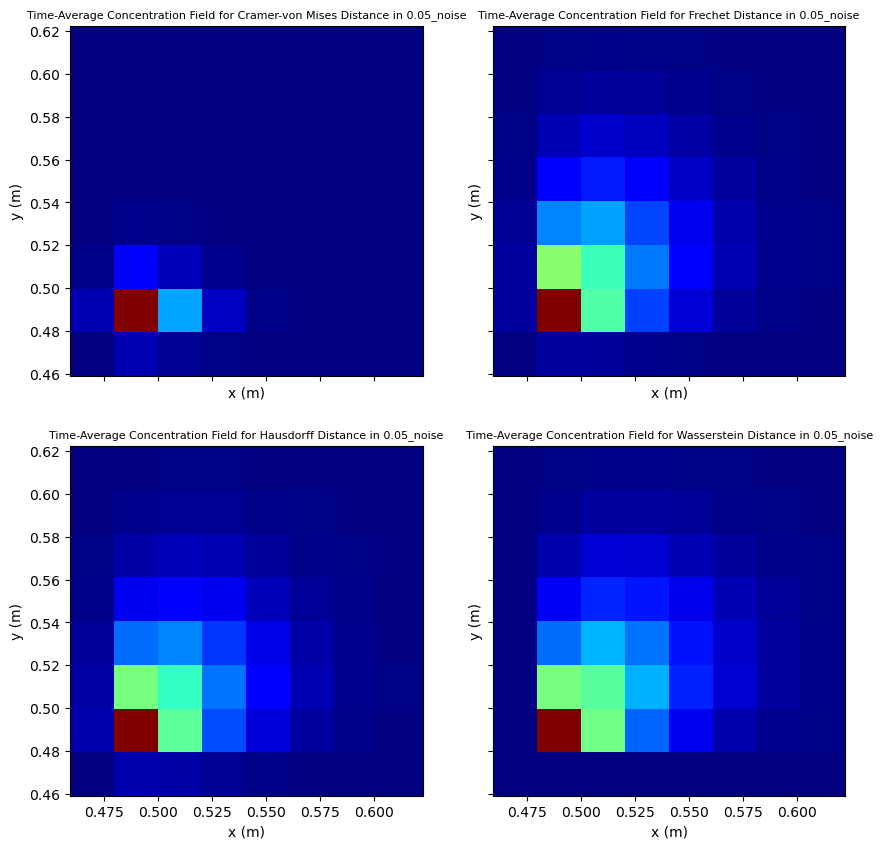

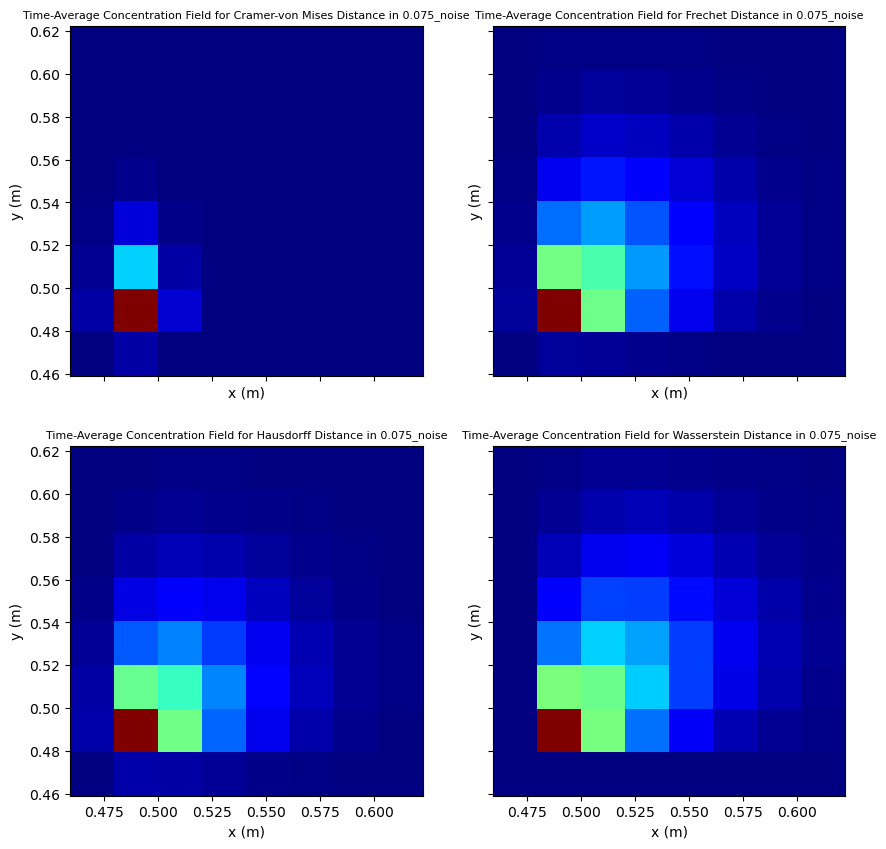

In [34]:
for model in MODELS:
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
    axes = axes.flatten()
    for i, metric in enumerate(METRICS):
        cx_metric = list(cx[(cx["model"] == model)][metric])[0]
        cy_metric = list(cy[(cy["model"] == model)][metric])[0]
        s_metric = list(s[(s["model"] == model)][metric])[0]

        sol = generate_solution(Nx, Ny, Lx, Ly, cx_metric, cy_metric, s_metric)
        X, Y = np.meshgrid(x[23:31], y[23:31])
        axes[i].pcolor(X, Y, np.mean(sol[23:31, 23:31, :], axis=2), cmap='jet', shading='auto')
        # axes[i].colorbar(label="Concentration per unit volume (kg/$m^3$)")
        axes[i].set_xlabel("x (m)")
        axes[i].set_ylabel("y (m)")
        axes[i].set_title(f"Time-Average Concentration Field for {metric} in {model}", fontsize=8)

plt.show()